# Football Analysis - Data Wrangling

First, we import all the required packages to work on the project:

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt
import geopy.distance
import seaborn as sns
pd.set_option('display.max_rows', 10)

In [0]:
maindf = pd.read_csv('https://raw.githubusercontent.com/harditsingh/DataWranglingVU/master/Project/EPL_Set.csv')

# Data Preparation

In [0]:
maindf.isnull().sum()

Div           0
Date          0
HomeTeam      0
AwayTeam      0
FTHG          0
           ... 
FTR           0
HTHG        924
HTAG        924
HTR         924
Season        0
Length: 11, dtype: int64

In [0]:
def parse_date(text):
  if type(text) is not str:
    return
  for fmt in ('%d/%m/%y', '%d/%m/%Y'):
      try:
          return datetime.strptime(text, fmt)
      except ValueError:
          pass
  raise ValueError('no valid date format found')

# Normalizing the date strings
maindf['Date'] = maindf['Date'].apply(parse_date)
# Dropping the half-time goals and half-time results, since the have missing values
maindf.drop(['HTHG', 'HTAG', 'HTR', 'Div'], inplace=True, axis=1)


In [0]:
# Unique list of teams in the premier league
unique_teams = list(set((maindf['HomeTeam'].unique().tolist() + maindf['AwayTeam'].unique().tolist())))
unique_teams.sort()

In [0]:
unique_teams.__len__()
print(unique_teams)

['Arsenal', 'Aston Villa', 'Barnsley', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Bradford', 'Brighton', 'Burnley', 'Cardiff', 'Charlton', 'Chelsea', 'Coventry', 'Crystal Palace', 'Derby', 'Everton', 'Fulham', 'Huddersfield', 'Hull', 'Ipswich', 'Leeds', 'Leicester', 'Liverpool', 'Man City', 'Man United', 'Middlesboro', 'Middlesbrough', 'Newcastle', 'Norwich', "Nott'm Forest", 'Oldham', 'Portsmouth', 'QPR', 'Reading', 'Sheffield United', 'Sheffield Weds', 'Southampton', 'Stoke', 'Sunderland', 'Swansea', 'Swindon', 'Tottenham', 'Watford', 'West Brom', 'West Ham', 'Wigan', 'Wimbledon', 'Wolves']


The thing is that according to this database, 50 unique teams have participated in the EPL. But accordind to [this article](https://en.wikipedia.org/wiki/List_of_Premier_League_clubs), only 49 teams have been a part of the EPL. When we look closely at the list, we realize that the Middlesboro and Middlesbrough are the same name. To normalize the names, we will be replacing the names in the dataset with the official full names of the teams.

In [0]:
names_df = pd.read_csv('https://raw.githubusercontent.com/harditsingh/DataWranglingVU/master/Project/names.csv')

In [0]:
name_dict = {}

for i in range(0,names_df.shape[0]):
  name_dict[names_df.loc[i][0]] = names_df.loc[i][1]
  
maindf.replace(name_dict, inplace=True)

unique_teams = list(set((maindf['HomeTeam'].unique().tolist() + maindf['AwayTeam'].unique().tolist())))
unique_teams.sort()

We then get data for the the attendance of these matches. Since we were unable to find the exact attendance data for each match, we use an average attendance based on the home team for each match

In [0]:
attendance_files = [ ('/' + str(i) + '_' + str(i+1) + '.csv') for i in range(1993, 2018)]

attendance_files.sort()
base_url = 'https://raw.githubusercontent.com/harditsingh/DataWranglingVU/master/Project/attendance'
attendance_files = [base_url + file_name for file_name in attendance_files]

attendance_data = {}

for i in range(0, maindf['Season'].unique().__len__()):
  temp_df = pd.read_csv(attendance_files[i], decimal=",")

  temp_df.drop('#', axis=1, inplace=True)
  temp_df.drop(temp_df.tail(1).index, inplace=True)
  
  temp_dict = {}
  for j in range(1, temp_df.shape[0] + 1):
    temp_dict[temp_df.loc[j]['Team']] = int(temp_df.loc[j]['average'].replace('.' , ''))
  
  attendance_data[maindf['Season'].unique()[i]] = temp_dict


We then add the attendance data to the main dataframe. The attendance figures for each match are the average attendance numbers for the home team of that match

In [0]:
maindf['Attendance'] = 0

for i in range(0, maindf.shape[0]):
  try:
    temp_attendance = attendance_data[maindf.iloc[i]['Season']][maindf.iloc[i]['HomeTeam']]
  except KeyError as e:
    temp_attendance = 0

  # Using set_value() instead of .at[]/.iat[] because of compututational time superiority
  maindf.set_value(i, 'Attendance', temp_attendance)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


We then import a dataset containing all the information about the home stadiums of all the teams. We use the geographical coordinates of all the stadiums to find the vincenty distance between all of the stadium, which would later be used to see if there is any correlation between the distance that the teams have to travel for a match and the results of the match

In [0]:
stadium_data = pd.read_csv('https://raw.githubusercontent.com/harditsingh/DataWranglingVU/master/Project/stadiums-premierleague-v2.csv')

In [0]:
stadium_distance = {}

for i in range(0, stadium_data.shape[0]):
  stadium_distance[stadium_data.iloc[i]['Team']] = {}
  for j in range(0, stadium_data.shape[0]):
    if i != j:
      coords_1 = (stadium_data.iloc[i]['Latitude'], stadium_data.iloc[i]['Longitude'])
      coords_2 = (stadium_data.iloc[j]['Latitude'], stadium_data.iloc[j]['Longitude'])

      distance = geopy.distance.vincenty(coords_1, coords_2).miles
      stadium_distance[stadium_data.iloc[i]['Team']][stadium_data.iloc[j]['Team']] = distance


**NOTE:** In the piece of code above, we add all the distances to a dict containing all the possible pairs of stadiums. This has been done to reduce computation versus calculating the distances on-the-fly, or making multiple passes over the dataframe

In [0]:
maindf['StadiumDistance'] = 0

for i in range(0, maindf.shape[0]):
  # Using set_value() instead of .at[]/.iat[] because of compututational time superiority
  maindf.set_value(i, 'StadiumDistance', stadium_distance[maindf.iloc[i]['HomeTeam']][maindf.iloc[i]['AwayTeam']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


Finally, after the cleanup, this is what are dataset looks like:

In [0]:
maindf

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,Attendance,StadiumDistance
0,1993-08-14,Arsenal FC,Coventry City,0,3,A,1993-94,30564,85
1,1993-08-14,Aston Villa,Queens Park Rangers,4,1,H,1993-94,29015,98
2,1993-08-14,Chelsea FC,Blackburn Rovers,1,2,A,1993-94,19416,183
3,1993-08-14,Liverpool FC,Sheffield Wednesday,2,0,H,1993-94,38503,60
4,1993-08-14,Manchester City,Leeds United,1,1,D,1993-94,26709,32
...,...,...,...,...,...,...,...,...,...
9659,2018-05-13,Newcastle United,Chelsea FC,3,0,H,2017-18,51992,248
9660,2018-05-13,Southampton FC,Manchester City,0,1,A,2017-18,30794,181
9661,2018-05-13,Swansea City,Stoke City,1,2,A,2017-18,20623,119
9662,2018-05-13,Tottenham Hotspur,Leicester City,5,4,H,2017-18,67953,83


# Basic Data Analysis
Before we move any further, we must analyze the data that we have currently to see if any trends are already visible. First, let's take a look at the match database.

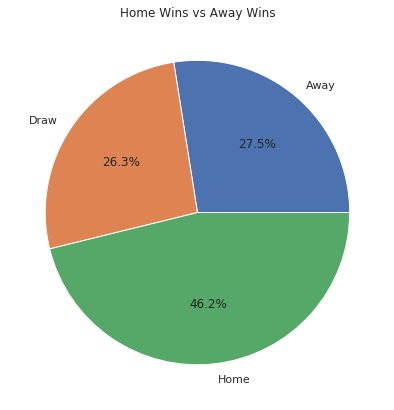

In [0]:
# Total home wins, away wins, draws
results = maindf.groupby('FTR')['FTR'].count()
plt.pie(results, labels=['Away', 'Draw', 'Home'], autopct='%1.1f%%')
plt.title('Home Wins vs Away Wins')
plt.show()

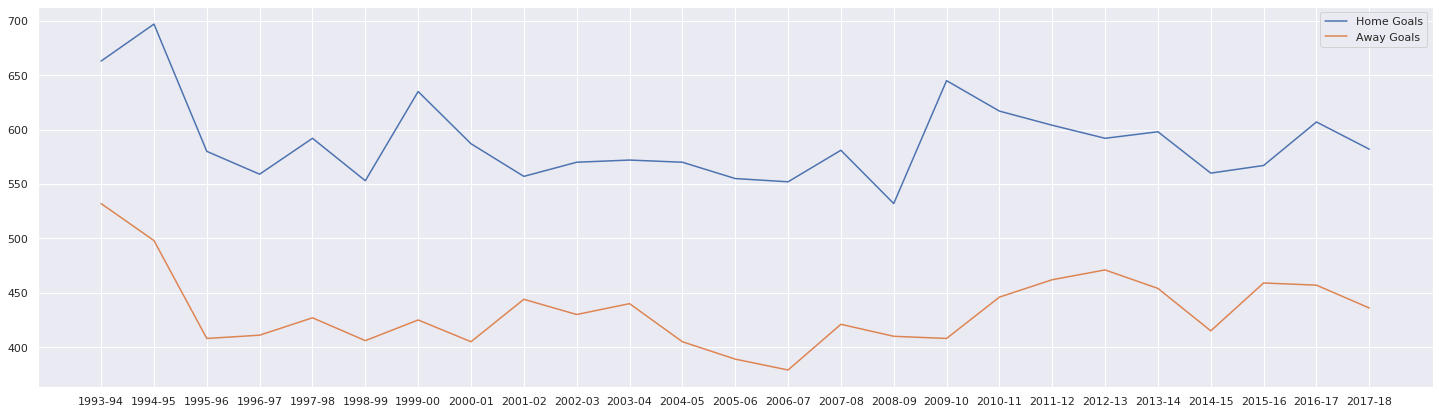

In [0]:
total_goals = maindf[['FTAG', 'FTHG', 'Season']]

sns.set(rc={'figure.figsize':(25,7)})
plt.plot(total_goals[['FTHG', 'Season']].groupby('Season').sum()['FTHG'], label='Home Goals')
plt.plot(total_goals[['FTAG', 'Season']].groupby('Season').sum()['FTAG'], label='Away Goals')
plt.legend()

# Major Data Analysis

## Checking for correlation

We start out by checking correlation between the obvious suspects with the home performance of the teams, the Stadium Distance and the Attendance

In [0]:
# We first create a column GoalDifference, which would be FTHG - FTAG
maindf['GoalDifference'] = maindf['FTHG'] - maindf['FTAG']
maindf

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,Attendance,StadiumDistance,GoalDifference
0,1993-08-14,Arsenal FC,Coventry City,0,3,A,1993-94,30564,85,-3
1,1993-08-14,Aston Villa,Queens Park Rangers,4,1,H,1993-94,29015,98,3
2,1993-08-14,Chelsea FC,Blackburn Rovers,1,2,A,1993-94,19416,183,-1
3,1993-08-14,Liverpool FC,Sheffield Wednesday,2,0,H,1993-94,38503,60,2
4,1993-08-14,Manchester City,Leeds United,1,1,D,1993-94,26709,32,0
...,...,...,...,...,...,...,...,...,...,...
9659,2018-05-13,Newcastle United,Chelsea FC,3,0,H,2017-18,51992,248,3
9660,2018-05-13,Southampton FC,Manchester City,0,1,A,2017-18,30794,181,-1
9661,2018-05-13,Swansea City,Stoke City,1,2,A,2017-18,20623,119,-1
9662,2018-05-13,Tottenham Hotspur,Leicester City,5,4,H,2017-18,67953,83,1


Now we'll take a look at the distributions of Stadium Distance and Attendance to check for skewness

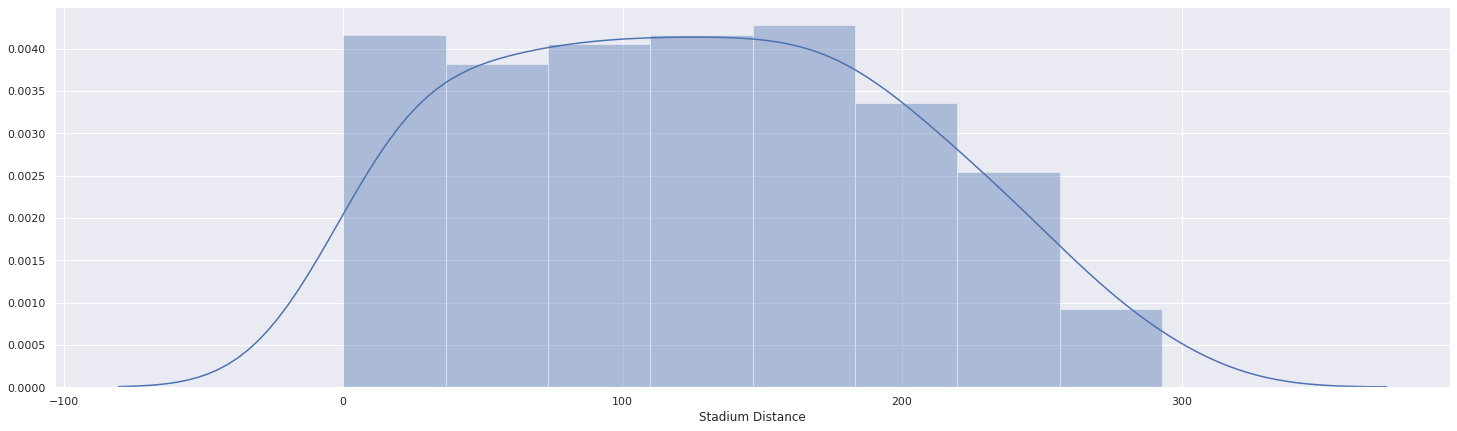

In [0]:
sns.distplot(maindf['StadiumDistance'].unique(), axlabel='Stadium Distance')

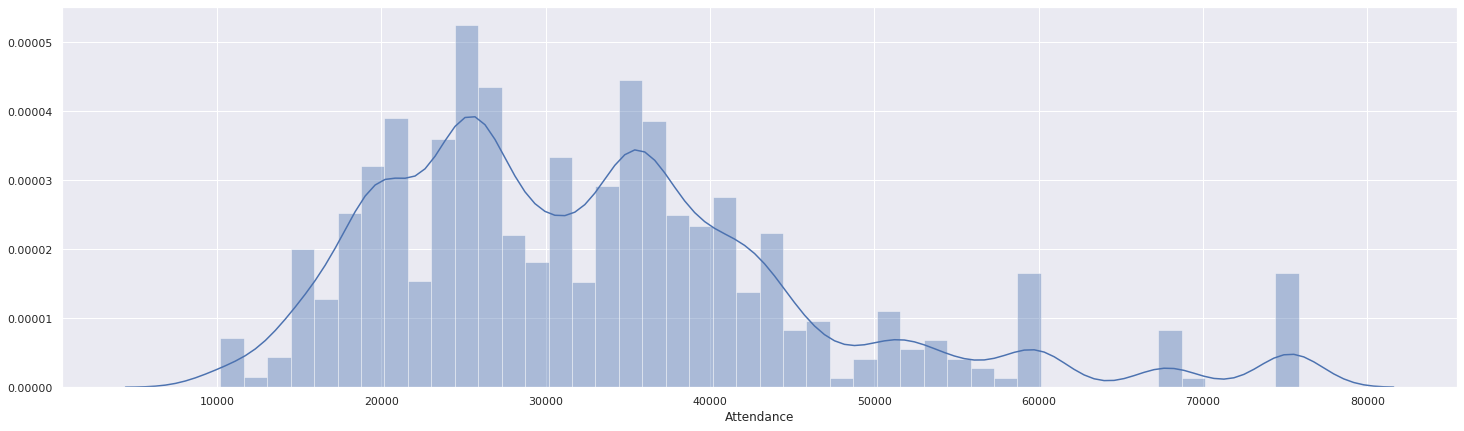

In [0]:
sns.distplot(maindf['Attendance'])

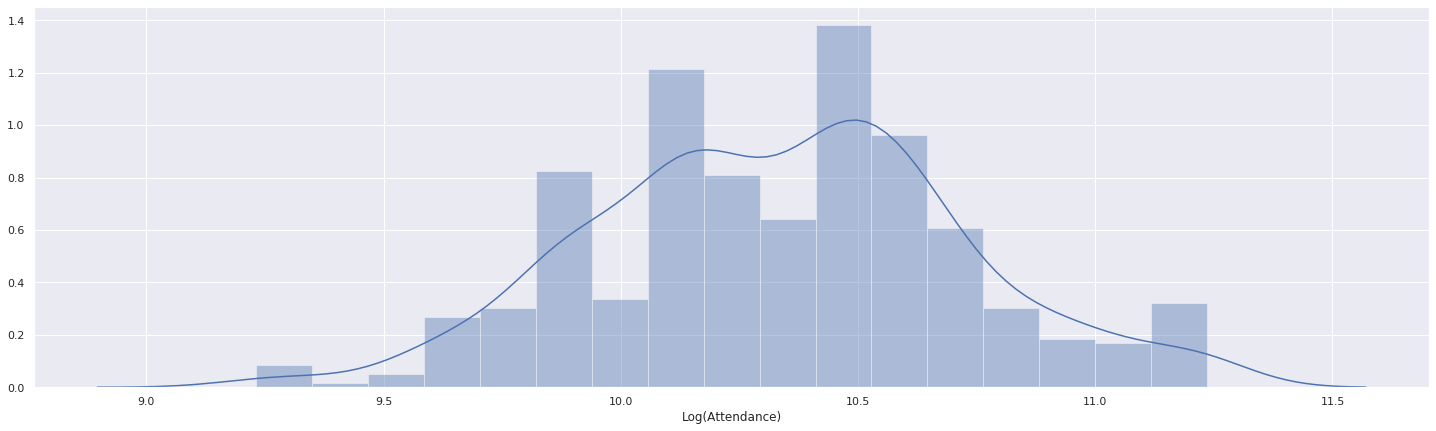

In [0]:
# Normalized attendance data
sns.distplot(np.log(maindf['Attendance'].unique()), axlabel='Log(Attendance)')

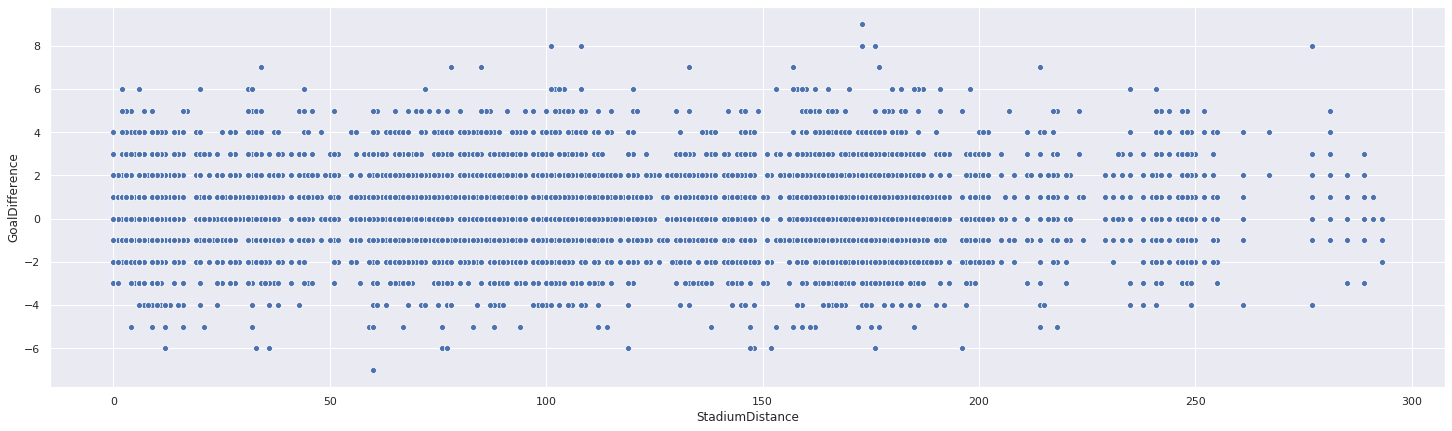

In [0]:
sns.scatterplot(maindf['StadiumDistance'], maindf['GoalDifference'])

Checking the Pearson's correlation coefficient for GoalDifference and StadiumDistance and GoalDifference and Log(Attendance)

In [0]:
np.corrcoef(maindf['GoalDifference'], maindf['StadiumDistance'])[0,1]

0.03843102099058685

In [0]:
np.corrcoef(maindf['GoalDifference'], np.log(maindf['Attendance']))[0,1]

0.22228906011096314

## Match Statitics
We will now create multiple different tables for the different aspects of the game of football, which will facilitate our analysis and help us in finding patterns

### Yearly Match Rankings

Here we create a point based ranking table, 3 points for a win, 1 point for a draw. 

In [0]:
match_results = {}

def get_results(result_table, winloss):
  try:
    result = result_table[winloss]
  except KeyError as e:
    result = 0
  return result


for season in maindf['Season'].unique():
  listtemp = []
  results_home = maindf[maindf['Season'] == season][['HomeTeam', 'FTR']].groupby('HomeTeam').FTR.value_counts()
  results_away = maindf[maindf['Season'] == season][['AwayTeam', 'FTR']].groupby('AwayTeam').FTR.value_counts()
  home_fthg = maindf[maindf['Season'] == season][['HomeTeam', 'GoalDifference']].groupby('HomeTeam').sum()
  away_ftag = maindf[maindf['Season'] == season][['AwayTeam', 'GoalDifference']].groupby('AwayTeam').sum()

  for key in unique_teams:
    try:
      wins = get_results(results_home[key], 'H') + get_results(results_away[key], 'A')
      losses = get_results(results_home[key], 'A') + get_results(results_away[key], 'H')
      draws = get_results(results_home[key], 'D') + get_results(results_away[key], 'D')
      goals = home_fthg.loc[key]['GoalDifference'] - away_ftag.loc[key]['GoalDifference']
      listtemp.append([key, wins, losses, draws, goals])
    except KeyError as e:
      continue
  
  match_results[season] = pd.DataFrame(listtemp, columns=['Team', 'Wins', 'Losses', 'Draws', 'GoalDifference'])
  match_results[season]['FinalPoints'] = (match_results[season]['Wins'] * 3) + match_results[season]['Draws']



The dict match_results contains dataframes for all seasons from 1993 up until 2018

In [0]:
match_results['2017-18'].sort_values(['FinalPoints', 'GoalDifference'], ascending=False)

,Team,Wins,Losses,Draws,GoalDifference,FinalPoints
10,Manchester City,32,2,4,79,100
11,Manchester United,25,7,6,40,81
16,Tottenham Hotspur,23,7,8,38,77
9,Liverpool FC,21,5,12,46,75
4,Chelsea FC,21,10,7,24,70
...,...,...,...,...,...,...
7,Huddersfield Town,9,19,10,-30,37
13,Southampton FC,7,16,15,-19,36
15,Swansea City,8,21,9,-28,33
14,Stoke City,7,19,12,-33,33


### Lifetime wins/losses
Here we calculate the lifetime wins and losses of all the teams that ever participated in the premier league

In [0]:
# Total lifetime wins/losses
listtemp = []

for key in unique_teams:
  wins = losses = draws = goals = 0

  for season in maindf['Season'].unique():
    
    results_home = maindf[maindf['Season'] == season][['HomeTeam', 'FTR']].groupby('HomeTeam').FTR.value_counts()
    results_away = maindf[maindf['Season'] == season][['AwayTeam', 'FTR']].groupby('AwayTeam').FTR.value_counts()
    home_fthg = maindf[maindf['Season'] == season][['HomeTeam', 'GoalDifference']].groupby('HomeTeam').sum()
    away_ftag = maindf[maindf['Season'] == season][['AwayTeam', 'GoalDifference']].groupby('AwayTeam').sum()

    try:
      wins += get_results(results_home[key], 'H') + get_results(results_away[key], 'A')
      losses += get_results(results_home[key], 'A') + get_results(results_away[key], 'H')
      draws += get_results(results_home[key], 'D') + get_results(results_away[key], 'D')
      goals += home_fthg.loc[key]['GoalDifference'] - away_ftag.loc[key]['GoalDifference']
    except KeyError as e:
      continue

  listtemp.append([key, wins, losses, draws, goals])

lifetime_results = pd.DataFrame(listtemp, columns=['Team', 'Wins', 'Losses', 'Draws', 'GoalDifference'])


In [0]:
lifetime_results.sort_values(['Wins', 'Draws', 'Losses'], ascending=False)

,Team,Wins,Losses,Draws,GoalDifference
26,Manchester United,605,150,203,1013
1,Arsenal FC,529,187,242,808
13,Chelsea FC,523,201,234,747
24,Liverpool FC,483,231,244,654
42,Tottenham Hotspur,407,307,244,219
...,...,...,...,...,...
31,Oldham Athletic,9,20,13,-26
9,Brighton & Hove Albion,9,16,13,-20
19,Huddersfield Town,9,19,10,-30
11,Cardiff City,7,22,9,-42


### Lifetime goals scored
Here we calculate the lifetime goals scored by all the teams that ever participated in the premier league

In [0]:
# Total lifetime goals
listtemp = []

for key in unique_teams:
  goals = 0

  for season in maindf['Season'].unique():
    home_fthg = maindf[maindf['Season'] == season][['HomeTeam', 'FTHG']].groupby('HomeTeam').sum()
    away_ftag = maindf[maindf['Season'] == season][['AwayTeam', 'FTAG']].groupby('AwayTeam').sum()

    try:
      goals += home_fthg.loc[key]['FTHG'] + away_ftag.loc[key]['FTAG']
    except KeyError as e:
      continue

  listtemp.append([key, goals])

lifetime_goals = pd.DataFrame(listtemp, columns=['Team', 'Goals'])


In [0]:
lifetime_goals.sort_values(['Goals'], ascending=False)

,Team,Goals
26,Manchester United,1857
1,Arsenal FC,1732
13,Chelsea FC,1656
24,Liverpool FC,1623
42,Tottenham Hotspur,1420
...,...,...
31,Oldham Athletic,42
3,Barnsley FC,37
9,Brighton & Hove Albion,34
11,Cardiff City,32


### Yearly goal difference
Here, we calculate the goal difference for all the teams that participated in the premier league, and then make a heatmap to visualize how each team performed. The grey cells indicate the fact that the team did not participate in the premier league in that season

In [0]:
# Yearly goal difference
listtemp = []

for key in unique_teams:
  team_list = [key]

  for season in maindf['Season'].unique():
    goal_difference = 0
    home_fthg = maindf[maindf['Season'] == season][['HomeTeam', 'GoalDifference']].groupby('HomeTeam').sum()
    away_ftag = maindf[maindf['Season'] == season][['AwayTeam', 'GoalDifference']].groupby('AwayTeam').sum()

    try:
      goal_difference += home_fthg.loc[key]['GoalDifference'] - away_ftag.loc[key]['GoalDifference']
    except KeyError as e:
      team_list.append(np.nan)
      continue

    team_list.append(goal_difference)
  listtemp.append(team_list)


cols = ['Teams'] + list(maindf['Season'].unique())
yearly_goal_difference = pd.DataFrame(listtemp, columns=cols)


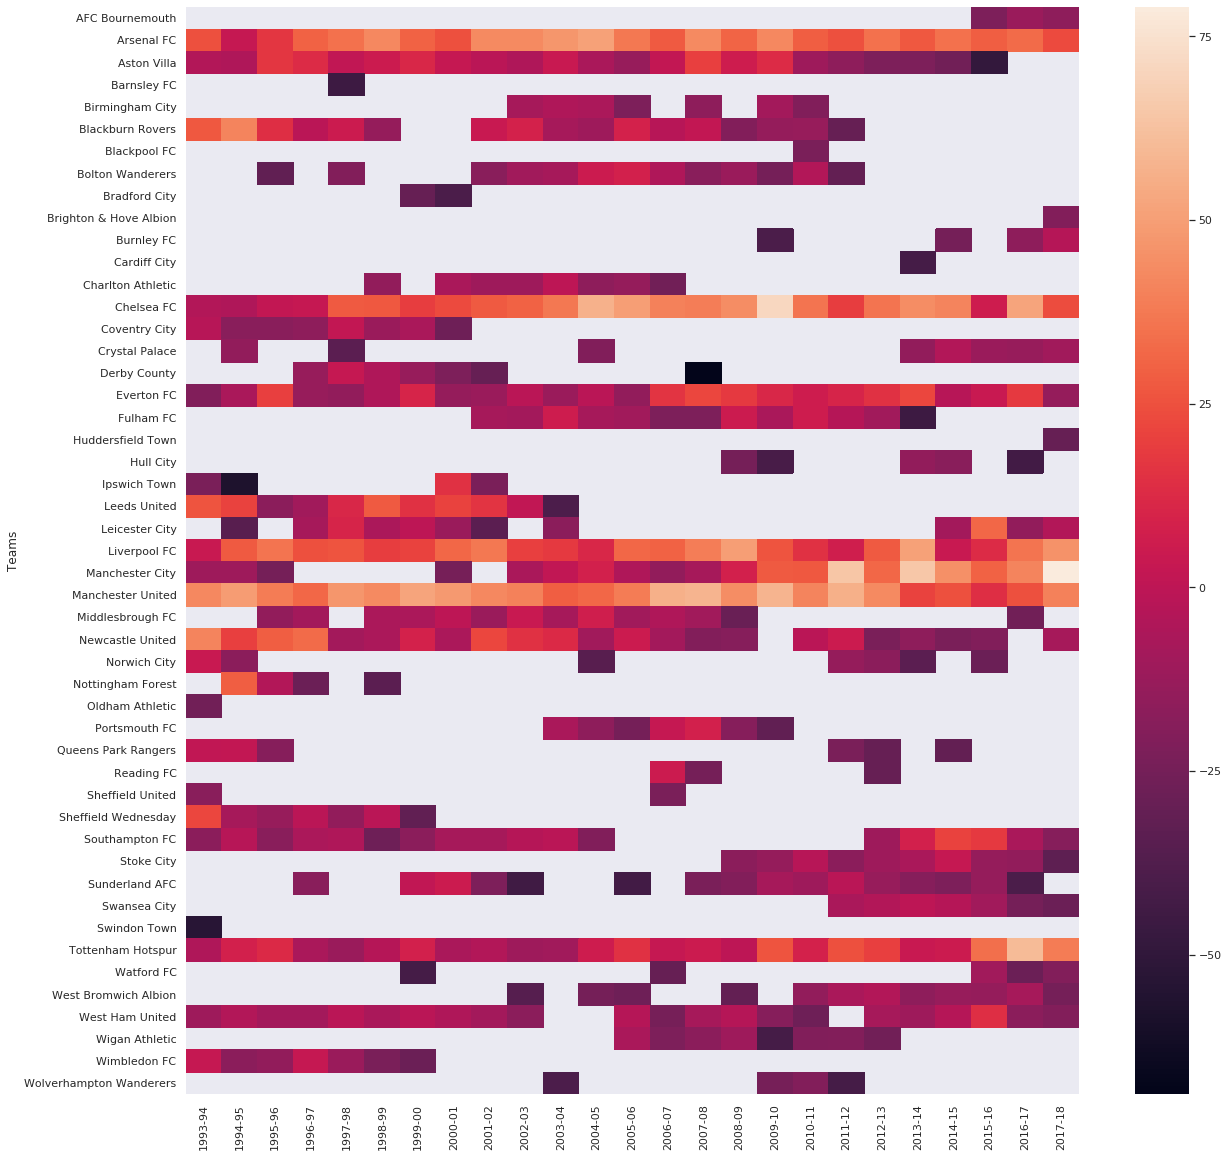

In [0]:
mask = yearly_goal_difference.set_index(['Teams']).isnull()
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(yearly_goal_difference.set_index(['Teams']), mask=mask)
sns.set(rc={'figure.figsize':(25,7)})

## Market Values
In this section, we import data for the market values for all the teams. Unfortunately, the only available data was from the year 2011 on, so we were unable to perform the analysis for the market value for years prior to 2011.

In [0]:
market_value_years = [('20' + str(i) + '-' + str(i+1)) for i in range(11, 19)]
market_value_files = [('/' + str(i) + '.csv') for i in range(2011, 2019)]

base_url = 'https://raw.githubusercontent.com/harditsingh/DataWranglingVU/master/Project/MarketValue'
market_value_files = [base_url + file_name for file_name in market_value_files]

market_value_data = {}

for team in unique_teams:
  market_value_data[team] = {} 

for i in range(0, market_value_files.__len__()):
  values = pd.read_csv(market_value_files[i])

  values = values[values.keys()[[2, 4]]].iloc[1:]
  values.columns = ['Team', 'Value']
  values.Value = values.Value.str.replace('€', '')
  values.Value = values.Value.str.replace('bn', 'b')
  values['Value'] = (values['Value'].replace(r'[kmb]+$', '', regex=True).astype(float) * values['Value'].str.extract(r'[\d\.]+([kmb]+)', expand=False).fillna(1).replace(['k','m', 'b'], [10**3, 10**6, 10**9]).astype(int))

  for j in range(1, values.shape[0]):
    market_value_data[values.loc[j]['Team']][market_value_years[i]] = values.loc[j]['Value']



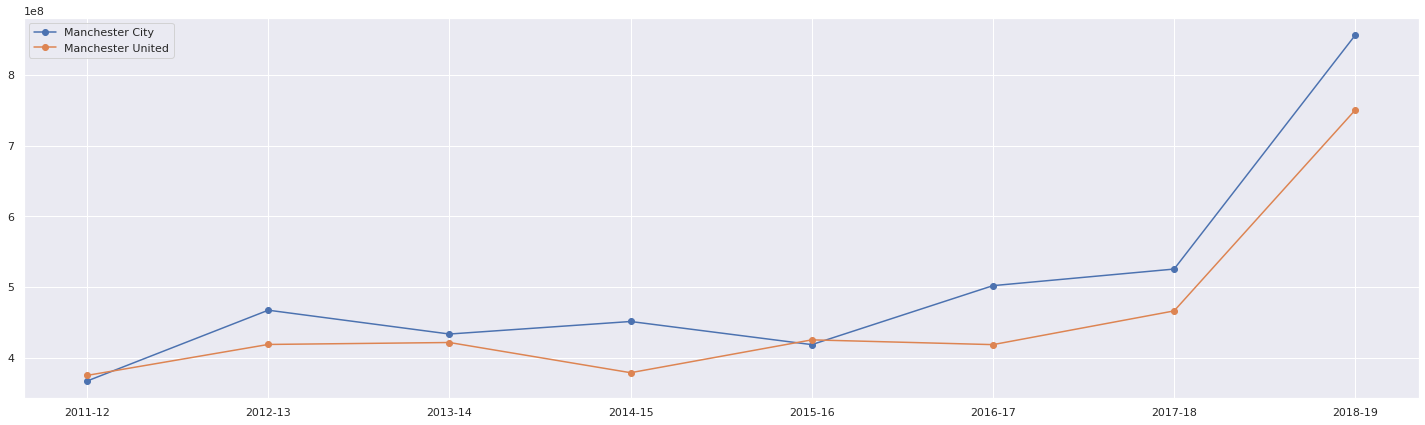

In [0]:
plt.plot(list(market_value_data['Manchester City'].keys()), list(market_value_data['Manchester City'].values()), marker='o', label="Manchester City")
plt.plot(list(market_value_data['Manchester United'].keys()), list(market_value_data['Manchester United'].values()), marker='o', label="Manchester United")
plt.legend()

## Home Advantage
To explore the home advantage further, we calculated home advantage score for each team for each year. This was an attempt to replicate the scores generated by the football statistics website Footystats([check out the table here](https://footystats.org/england/premier-league/home-advantage-table)). 

After some brainstorming, we came up with some formulas which seemed to give us similar results:
![formulas for home advantage scores](https://github.com/harditsingh/DataWranglingVU/raw/master/Project/home_advantage_scoring_formula.png)

In [0]:
scoring_advantage_dict = {}

for season in maindf['Season'].unique():
  listtemp = []
  home_fthg = maindf[maindf['Season'] == season][['HomeTeam', 'FTHG']].groupby('HomeTeam').sum()
  away_ftag = maindf[maindf['Season'] == season][['AwayTeam', 'FTAG']].groupby('AwayTeam').sum()

  for key in unique_teams:
    try:
      home = home_fthg.loc[key]['FTHG'] / 19
      away = away_ftag.loc[key]['FTAG'] / 19
      scoring_advantage = (home - away) / (home + away) * 100
      listtemp.append([key, scoring_advantage, home, away ])
    except KeyError as e:
      continue
  
  scoring_advantage_dict[season] = pd.DataFrame(listtemp, columns=['Team', 'ScoringAdvantage', 'Home', 'Away'])


In [0]:
defense_advantage_dict = {}

for season in maindf['Season'].unique():
  listtemp = []
  home_fthg = maindf[maindf['Season'] == season][['HomeTeam', 'FTAG']].groupby('HomeTeam').sum()
  away_ftag = maindf[maindf['Season'] == season][['AwayTeam', 'FTHG']].groupby('AwayTeam').sum()

  for key in unique_teams:
    try:
      home = home_fthg.loc[key]['FTAG'] / 19
      away = away_ftag.loc[key]['FTHG'] / 19
      scoring_advantage = (away - home) / (home + away) * 100
      listtemp.append([key, scoring_advantage, home, away ])
    except KeyError as e:
      continue
  
  defense_advantage_dict[season] = pd.DataFrame(listtemp, columns=['Team', 'DefenseAdvantage', 'Home', 'Away'])


In [0]:
home_advantage_dict = {}

for season in maindf['Season'].unique():
  home_advantage_dict[season] = scoring_advantage_dict[season][['Team', 'ScoringAdvantage']]
  home_advantage_dict[season]['DefenseAdvantage'] = defense_advantage_dict[season]['DefenseAdvantage']
  home_advantage_dict[season]['HomeAdvantage'] = (home_advantage_dict[season]['ScoringAdvantage'] + home_advantage_dict[season]['DefenseAdvantage']) / 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
home_advantage_dict['2015-16'].sort_values(by=['HomeAdvantage'], ascending=False)

,Team,ScoringAdvantage,DefenseAdvantage,HomeAdvantage
10,Newcastle United,45.454545,26.153846,35.804196
9,Manchester United,10.204082,48.571429,29.387755
11,Norwich City,33.333333,10.447761,21.890547
1,Arsenal FC,-4.615385,38.888889,17.136752
14,Sunderland AFC,-4.166667,35.483871,15.658602
...,...,...,...,...
4,Crystal Palace,-2.564103,9.803922,3.619910
6,Leicester City,2.941176,0.000000,1.470588
19,West Ham United,4.615385,-1.960784,1.327300
0,AFC Bournemouth,2.222222,-1.492537,0.364842


We then prepared the yearly home advantage scores in order to plot them and compare the performances of the teams

In [0]:
listtemp = []

for key in unique_teams:
  team_list = [key]

  for season in maindf['Season'].unique():
    goals = 0
    temp = home_advantage_dict[season][home_advantage_dict[season]['Team'] == key]['HomeAdvantage'].values
    home_advantage = np.nan if (temp.__len__() == 0) else temp[0]
    try:
      team_list.append(home_advantage)
    except KeyError as e:
      team_list.append(np.nan)
      continue

  listtemp.append(team_list)

cols = ['Teams'] + list(maindf['Season'].unique())

yearly_home_advantage = pd.DataFrame(listtemp, columns=cols)


We also calculated the mean home advantage scores for each season in order to have a better perspective about the situation every season

In [0]:
transposed = yearly_home_advantage.set_index('Teams').T
transposed['Mean'] = transposed.mean(axis = 1, skipna = True) 

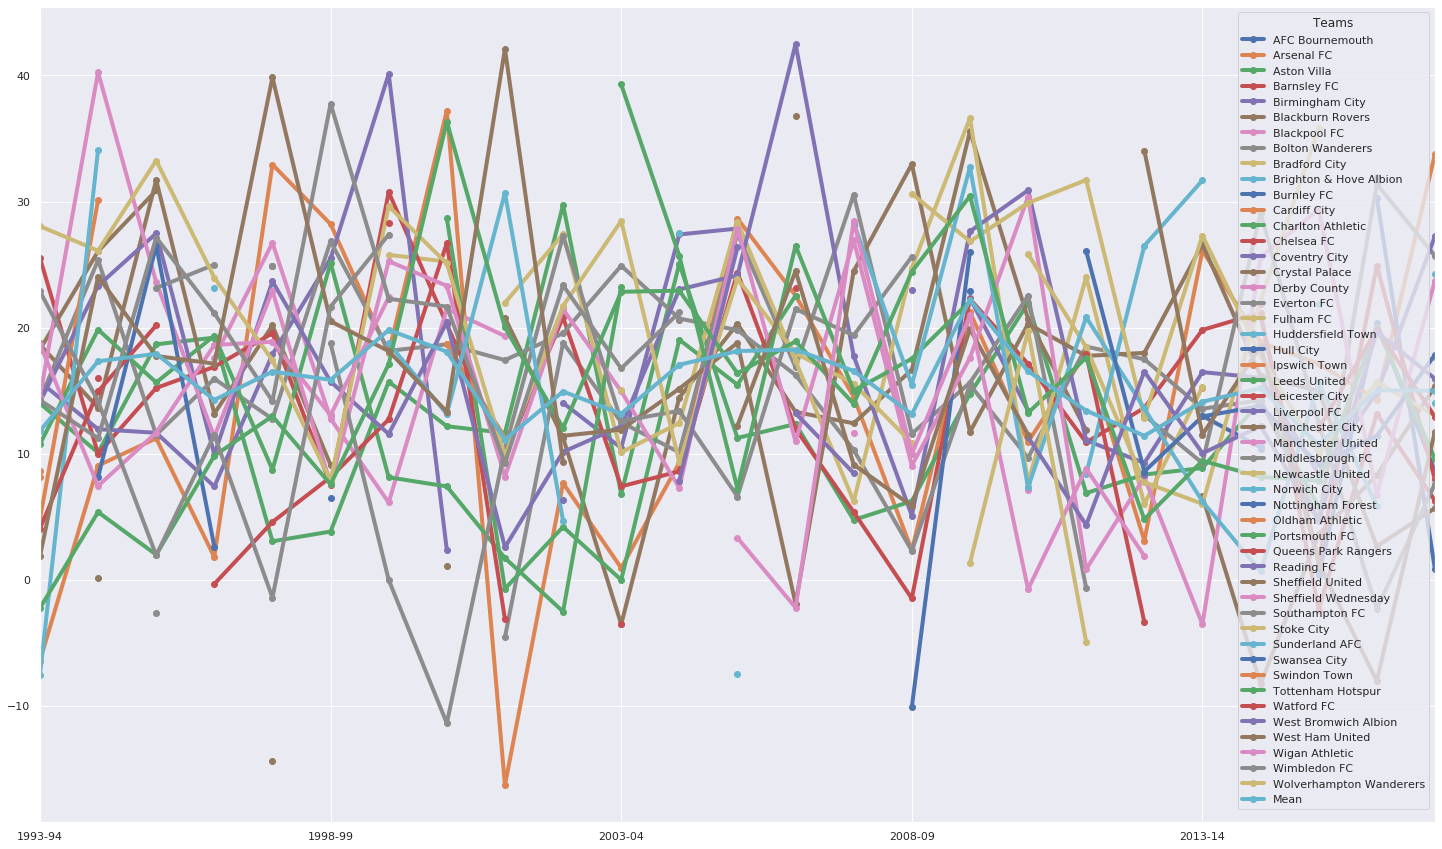

In [0]:
sns.set(rc={'figure.figsize':(25,15)})
transposed.plot.line(marker='o', linewidth=4)

We plot the home advantage score figures for Leicester City and Manchester United, since they both shone as outliers during the analysis

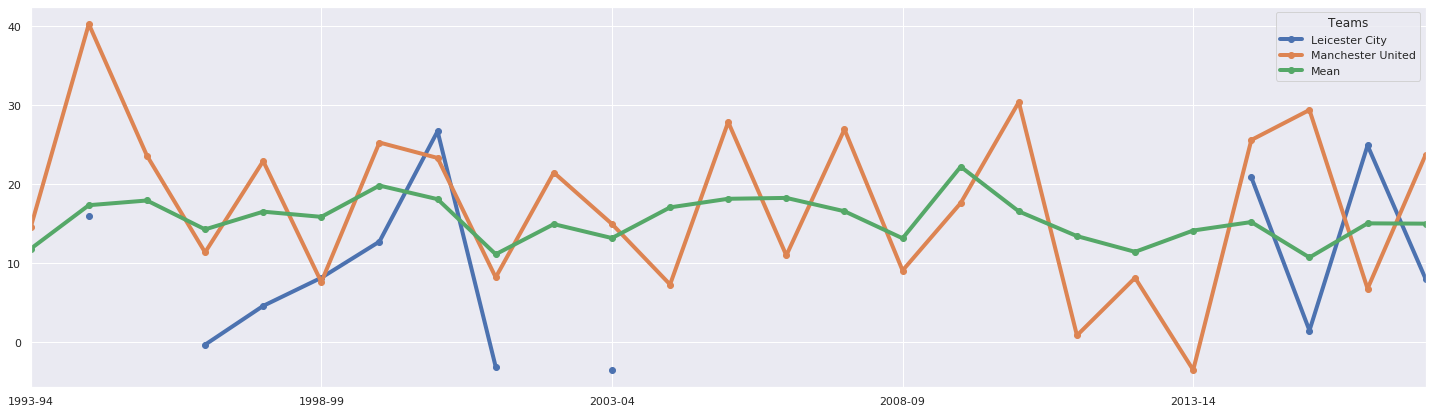

In [0]:
sns.set(rc={'figure.figsize':(25,7)})
transposed[['Leicester City', 'Manchester United', 'Mean']].plot.line(marker='o', linewidth=4)